In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report 


%matplotlib inline
pio.renderers.default='iframe'

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [2]:
df = pd.read_pickle("../../data_lake/output/train.pkl")
val = pd.read_pickle("../../data_lake/output/val.pkl")

# 2.0 EDA

In [3]:
df = df.drop(columns=['dist2','customer_id','TransactionID'])
val = val.drop(columns=['dist2','customer_id','TransactionID'])

In [4]:
df = df.rename(columns={'id_31':'browser'})
val = val.rename(columns={'id_31':'browser'})

In [5]:
df['P_emaildomain'] = df['P_emaildomain'].mask(df['P_emaildomain']=='gmail','gmail.com')
val['P_emaildomain'] = val['P_emaildomain'].mask(val['P_emaildomain']=='gmail','gmail.com')

In [6]:
df['R_emaildomain'] = df['R_emaildomain'].mask(df['R_emaildomain']=='gmail','gmail.com')
val['R_emaildomain'] = val['R_emaildomain'].mask(val['R_emaildomain']=='gmail','gmail.com')

In [7]:
df['id_30'] = df['id_30'].replace(" ","_",regex=True)
df['id_30'] = df['id_30'].str.replace(".","_",regex=False)

In [8]:
val['id_30'] = val['id_30'].replace(" ","_",regex=True)
val['id_30'] = val['id_30'].str.replace(".","_",regex=False)

In [9]:
df['browser'] = df['browser'].mask(df['browser'].str.contains('SM') | df['browser'].str.contains('ZTE'),'other')
val['browser'] = val['browser'].mask(val['browser'].str.contains('SM') | val['browser'].str.contains('ZTE'),'other')

In [10]:
df['browser'] = df['browser'].astype(str)
val['browser'] = val['browser'].astype(str)

In [11]:
df['browser_enc'] = 'other'
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('ie'),'ie')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('safari'),'safari')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('edge'),'edge')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('firefox'),'firefox')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('android'),'android')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('Android'),'android')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('chrome'),'chrome')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('opera'),'opera')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('google'),'chrome')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('samsung'),'android')

In [12]:
val['browser_enc'] = 'other'
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('ie'),'ie')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('safari'),'safari')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('edge'),'edge')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('firefox'),'firefox')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('android'),'android')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('Android'),'android')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('chrome'),'chrome')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('opera'),'opera')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('google'),'chrome')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('samsung'),'android')

In [13]:
df['DeviceType'] = df['DeviceType'].mask(df['browser']== 'ie 11.0 for tablet','tablet')
val['DeviceType'] = val['DeviceType'].mask(val['browser']== 'ie 11.0 for tablet','tablet')

In [14]:
df = df.drop(columns='browser')
val = val.drop(columns='browser')

In [15]:
df['device_info'] = df['DeviceInfo'].replace("-","_",regex=True)
df['device_info2'] = df['device_info'].replace(" ","_",regex=True)
df['device_info'] = df['DeviceInfo'].replace("-","_",regex=True)
df['device_info2'] = df['device_info'].replace(" ","_",regex=True)
df['device_info3'] = df['device_info2'].str.split("_").str[0]
df['device_info3'] = df['device_info3'].str.lower()

In [16]:
val['device_info'] = val['DeviceInfo'].replace("-","_",regex=True)
val['device_info2'] = val['device_info'].replace(" ","_",regex=True)
val['device_info'] = val['DeviceInfo'].replace("-","_",regex=True)
val['device_info2'] = val['device_info'].replace(" ","_",regex=True)
val['device_info3'] = val['device_info2'].str.split("_").str[0]
val['device_info3'] = val['device_info3'].str.lower()

In [17]:
df['device_info_v4'] = 'other'
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='windows') | (df['device_info3']=='microsoft') | (df['device_info3']=='trident/7.0')),'windows')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='ios') | (df['device_info3']=='iphone')),'ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='blade','blade')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='lenovo','lenovo')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='redmi','redmi')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='pixel','pixel')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='android','android')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='alcatel','alcatel')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='nokia','nokia')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='asus','asus')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='oneplus','oneplus')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='zte','zte')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='hisense','hisense')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='linux','linux')
df['device_info_v4'] = df['device_info_v4'].mask((df['device_info3'].str.contains("lg") | (df['device_info3'].str.contains("nexus"))),'lg')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3'].str.contains("huawei")) | (df['device_info3'].str.contains("hi6210sft"))),'huawei')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='motog3') |(df['device_info3']=='moto')),'moto')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='sm') |(df['device_info3']=='samsung')),'samsung')

In [18]:
val['device_info_v4'] = 'other'
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='windows') | (val['device_info3']=='microsoft') | (val['device_info3']=='trident/7.0')),'windows')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='ios') | (val['device_info3']=='iphone')),'ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='blade','blade')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='lenovo','lenovo')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='redmi','redmi')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='pixel','pixel')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='android','android')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='alcatel','alcatel')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='nokia','nokia')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='asus','asus')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='oneplus','oneplus')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='zte','zte')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='hisense','hisense')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='linux','linux')
val['device_info_v4'] = val['device_info_v4'].mask((val['device_info3'].str.contains("lg") | (val['device_info3'].str.contains("nexus"))),'lg')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3'].str.contains("huawei")) | (val['device_info3'].str.contains("hi6210sft"))),'huawei')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='motog3') |(val['device_info3']=='moto')),'moto')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='sm') |(val['device_info3']=='samsung')),'samsung')

In [19]:
df = df.drop(columns=['device_info','device_info2','device_info3','DeviceInfo'])
val = val.drop(columns=['device_info','device_info2','device_info3','DeviceInfo'])

In [20]:
df = df.drop(columns=['card1', 'card2', 'card3','card5', 'card6','M4', 'id_21', 'id_22',
                      'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38']) #'
val = val.drop(columns=['card1', 'card2', 'card3','card5', 'card6','M4', 'id_21', 'id_22',
                        'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38'])# 

In [21]:
def model_training(X_train, y_train, numerical_cols, categorical_cols,parameters):
    """
    
    """
    
    ##
    numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1,verbose=0),random_state=1,verbose=0,add_indicator=True)),
                                     ("scaler", MinMaxScaler())])
    categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',verbose=0,add_indicator=True)),
                                           ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
                                               ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
    pipe_model = GradientBoostingClassifier(random_state=0,n_iter_no_change=25,warm_start=True,max_features='auto')
    ##
    model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', pipe_model)])
    ##
    model.fit(X_train,y_train)
    model_grid = GridSearchCV(model,parameters,cv=4,scoring='accuracy',verbose=0,return_train_score=True).fit(X_train,y_train)
    print('GridSearchCV results...')
    print("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
    print("Mean CV Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))
    print("Best Parameters: \n{}\n".format(model_grid.best_params_))
    
    return model_grid

In [22]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [23]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [24]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [25]:
parameters = {'model__max_depth':[2,4,6],'model__n_estimators':[100,200,400],'model__learning_rate':[0.05,0.5,0.1]}

In [26]:
model = model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.77204011 0.7850379  0.79907389 0.80864567 0.82066763 0.83432992
 0.84593657 0.85837383 0.87334414 0.81684731 0.83410147 0.84388082
 0.86854773 0.8798432  0.88083988 0.91721744 0.92433953 0.92433953
 0.7845396  0.79884553 0.81128269 0.82259865 0.8360948  0.85567461
 0.85949506 0.87664557 0.90048175]

Mean CV Scores: 
[0.76896659 0.77843457 0.78977125 0.79463024 0.80216728 0.80820953
 0.81126162 0.81649393 0.82459161 0.79793165 0.80515747 0.81144908
 0.81848737 0.82241143 0.82234915 0.82795513 0.82882708 0.82882708
 0.77943108 0.7884007  0.7973083  0.80285249 0.80839652 0.81512366
 0.81811326 0.82328333 0.83144352]

Best Parameters: 
{'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 400}



In [27]:
def model_evaluation(model,X_test,y_test):
    """
    
    """
    print('Test results...')
    y_test_predict_grid = model.predict(X_test)    
    print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
    print('--------------------------------------------------')
    print('Model Test Confusion Matrix')
    cm = confusion_matrix(y_test,y_test_predict_grid,normalize='true') 
    cmd = ConfusionMatrixDisplay(cm,display_labels=['No','Yes'])
    cmd.plot()
    print('Classification report : \n',classification_report(y_test, y_test_predict_grid))

    ##
    feature_importances = model.best_estimator_.named_steps['model'].feature_importances_
    feature_names = X_test.columns
    lista = []
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    #         print('{}: {}'.format(name, score))
            lista.append(name)
    print('First ten features by importances:')
    print(lista[0:15])
    
    return model

In [28]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [29]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

Test results...
Model Test Accuracy: 0.8447423156921655
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     19976
         1.0       0.31      0.83      0.45      1659

    accuracy                           0.84     21635
   macro avg       0.65      0.84      0.68     21635
weighted avg       0.93      0.84      0.87     21635

First ten features by importances:
['ProductCD', 'TransactionAmt', 'card4', 'id_30', 'id_32', 'id_33', 'max_c', 'R_emaildomain', 'DeviceType', 'num_transactio_per_time', 'device_info_v4', 'addr2', 'id_34', 'addr1', 'max_d']


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_preprocessor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                                         random_state=1),
                                                                                                           random_state=1)),
                                                                                         ('scaler',
                                                                  

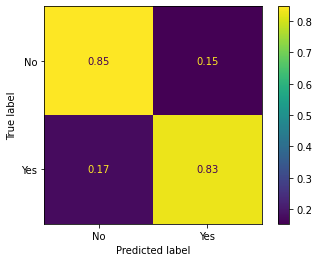

In [30]:
model_evaluation(model,X_val,y_val)

In [31]:
df['proba'] = model.predict_proba(df[X_train.columns])[:,1]
val['proba'] = model.predict_proba(val[X_train.columns])[:,1]

In [32]:
val.sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
27684,0,100.000,R,mastercard,299.0,87.0,anonymous.com,anonymous.com,Windows_7,24.0,1920x1080,match_status:2,desktop,2.0,885.958313,1,0,firefox,windows,0.020672
78655,0,61.326,C,visa,nan,nan,hotmail.com,hotmail.com,nan,nan,nan,nan,desktop,4.0,231.708328,1,0,chrome,windows,0.386245
120746,0,30.000,S,mastercard,203.0,87.0,nan,yahoo.com,Windows_10,24.0,1919x1079,match_status:2,desktop,5.0,37.000000,1,0,edge,windows,0.559959


In [33]:
df.sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
7144,0,200.000,R,visa,220.0,87.0,anonymous.com,msn.com,Windows_10,24.0,1920x1080,match_status:2,desktop,1.0,122.791664,1,0,chrome,windows,0.013699
102823,1,13.655,C,visa,nan,nan,hotmail.com,hotmail.com,nan,nan,nan,nan,desktop,7.0,247.875000,1,0,chrome,other,0.605305
44736,0,75.000,R,visa,512.0,87.0,gmail.com,gmail.com,iOS_10_2_0,32.0,2208x1242,match_status:1,mobile,1.0,0.000000,1,0,safari,ios,0.083518


In [34]:
val['isFraud'].value_counts()

0    19976
1     1659
Name: isFraud, dtype: int64

In [35]:
val[val['isFraud']=='1'].sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
131148,1,12.296,C,visa,nan,nan,gmail.com,gmail.com,nan,nan,nan,nan,mobile,20.0,90.0,1,0,chrome,samsung,0.926240
55095,1,21.513,C,visa,nan,nan,gmail.com,gmail.com,nan,nan,nan,nan,mobile,1.0,61.0,1,0,chrome,moto,0.478996
127918,1,181.120,C,visa,nan,nan,gmail.com,gmail.com,nan,nan,nan,nan,mobile,1.0,302.0,1,0,chrome,samsung,0.764893
